In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Sample synthetic dataset with Time and V1-V27 columns
data = {
    'Time': [10, 20, 30, 40, 50, 60, 70],
    'V1': [0.1, -1.2, 0.5, 0.9, -0.5, 1.3, -0.8],
    'V2': [-0.3, 1.5, 0.4, -1.1, 0.8, -1.0, 1.2],
    'V3': [0.7, -0.2, -0.9, 0.5, 1.1, -0.6, 0.3],
    'V4': [-0.5, 0.8, 1.2, -1.3, 0.4, -0.7, 1.5],
    # More columns for V5 to V27...
    'V5': [0.5, -0.1, -0.8, 0.2, 0.9, -0.5, 0.7],
    'is_fraud': [0, 1, 0, 0, 1, 0, 0]  # 1 indicates fraud, 0 indicates non-fraud
}
df = pd.DataFrame(data)

# Define the features (Time and V1 to V5 in this example)
X = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5']]
y = df['is_fraud']

# Set up the LLM (ChatGPT via Langchain) to generate hidden features
# Define a prompt template
prompt = PromptTemplate(
    input_variables=["time", "v1", "v2", "v3", "v4", "v5"],
    template="Generate a hidden feature based on the following transaction data: Time {time}, V1 {v1}, V2 {v2}, V3 {v3}, V4 {v4}, V5 {v5}. Provide a numerical feature."
)

# Initialize the LLM (GPT model from OpenAI via Langchain)
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.5)

# Create the LLMChain for generating hidden features
llm_chain = LLMChain(prompt=prompt, llm=llm)

# Function to generate a hidden feature using the LLM
def generate_hidden_feature(row):
    result = llm_chain.run({
        'time': row['Time'], 
        'v1': row['V1'], 
        'v2': row['V2'], 
        'v3': row['V3'], 
        'v4': row['V4'], 
        'v5': row['V5']
    })
    # Ensure the result is a number (parsing may be required if the response is in text form)
    try:
        return float(result)
    except ValueError:
        return 0.0  # Default value if parsing fails

# Apply the LLM to generate hidden features for each transaction
df['hidden_feature'] = df.apply(generate_hidden_feature, axis=1)

# Now the 'hidden_feature' column contains synthetic data generated by the LLM
# Combine the new hidden feature with the original features
X_with_hidden = pd.concat([X, df['hidden_feature']], axis=1)

# Train-test split with the new feature
X_train, X_test, y_train, y_test = train_test_split(X_with_hidden, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier using the original and hidden features
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with hidden feature: {accuracy}")

# Output the updated DataFrame with the new hidden feature
print(df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'hidden_feature', 'is_fraud']])


ModuleNotFoundError: No module named 'pandas'

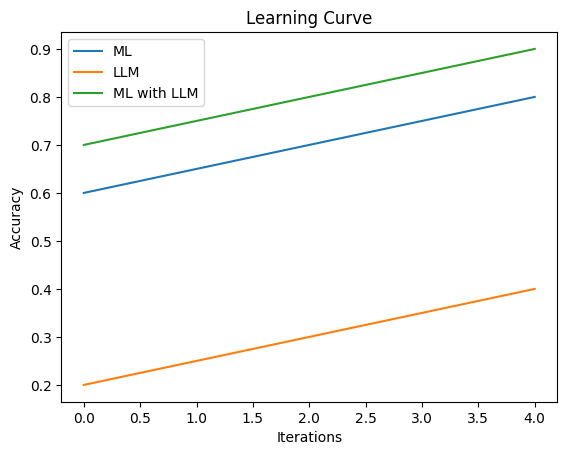

In [3]:
import matplotlib.pyplot as plt

plt.plot([0, 1, 2, 3, 4], [0.6, 0.65, 0.7, 0.75, 0.8], label='ML')

plt.plot([0, 1, 2, 3, 4], [0.2, 0.25, 0.3, 0.35, 0.4], label='LLM')

plt.plot([0, 1, 2, 3, 4], [0.7, 0.75, 0.8, 0.85, 0.9], label='ML with LLM')

plt.xlabel('Iterations')

plt.ylabel('Accuracy')

plt.title('Learning Curve')

plt.legend()

plt.show()